# Proyecto 2: Procesamiento de lenguaje natural con tweets de desastres

- Marco Fuentes - 18188
- Andy Castillo - 18040
- Francisco Rosal - 18676
- Gian Luca Rivera - 18049

## Problema científico
Twitter se ha convertido en un importante canal de comunicación en tiempos de emergencia. La ubicuidad de los teléfonos inteligentes permite a las personas anunciar una emergencia que están observando en tiempo real. Debido a esto, más agencias (organizaciones de socorro, agencias de noticias) están interesadas en monitorear programáticamente Twitter, sin embargo, no siempre está claro si las palabras de una persona realmente anuncian un desastre.


## Objetivo
Crear modelos de aprendizaje automático que permita predecir qué tweets son sobre desastres reales y cuáles no.

---

## Librerias

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS

## Datos

In [2]:
data = pd.read_csv("train.csv")

## Limpieza y preprocesamiento

Verificamos si hay tweets duplicados.

In [3]:
duplicated_data = data['text'].duplicated().sum()
print(f'Existen {duplicated_data} tweets duplicados')

Existen 110 tweets duplicados


Eliminamos los tweets duplicados ya que representan una pequeña parte del total de tweets.

In [4]:
data = data.drop_duplicates(subset=['text'], keep='first')

Convertimos todo el texto del tweet a minuscula, eliminamos los hipervinculos y caracteres especiales para que no esten las menciones ni los hashtag.

In [5]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'http[s]?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)

    text = " ".join(text.split())
    
    return text
    

In [6]:
data['text'] = data['text'].apply(clean_data)

## Análisis exploratorio

### Dataset general

In [7]:
rows = len(data)
columns = len(data.columns)
print("Columnas: ", columns, " | ", "Filas: ", rows)

Columnas:  5  |  Filas:  7503


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [9]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


### Keyword

Text(0, 0.5, 'Palabra')

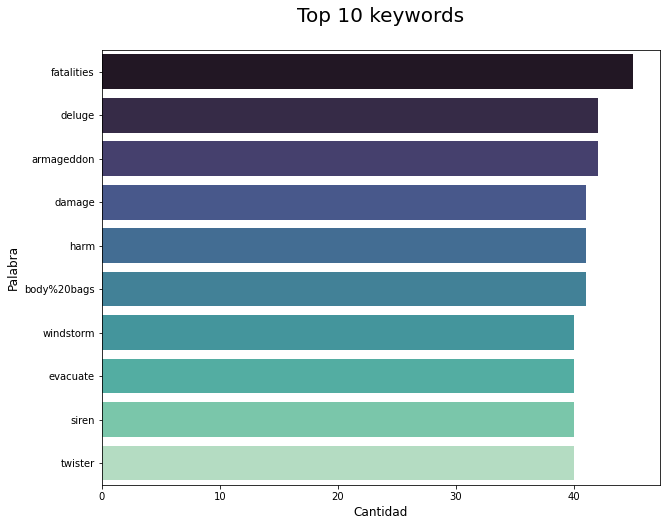

In [10]:
plt.figure(figsize=(10, 8))
keywords = data['keyword'].value_counts().nlargest(10)
sns.barplot(x=keywords.tolist(), y=keywords.index, orient='h', palette='mako')
plt.title('Top 10 keywords\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)

### Location

Text(0, 0.5, 'Palabra')

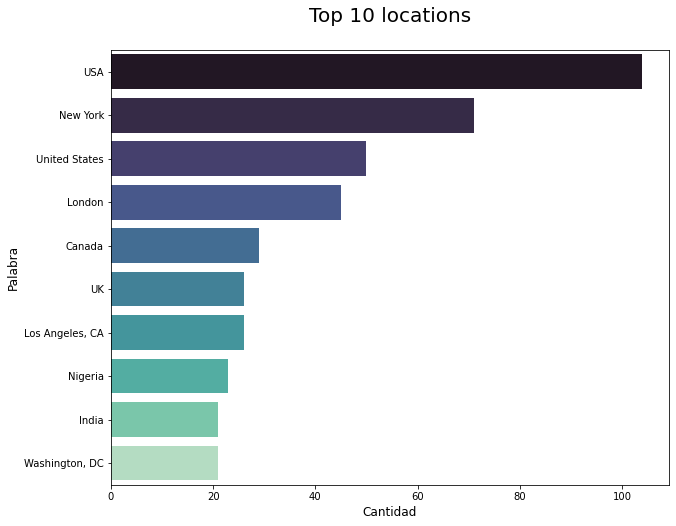

In [11]:
plt.figure(figsize=(10, 8))
locations = data['location'].value_counts().nlargest(10)
sns.barplot(x=locations.tolist(), y=locations.index, orient='h', palette='mako')
plt.title('Top 10 locations\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)

### Text

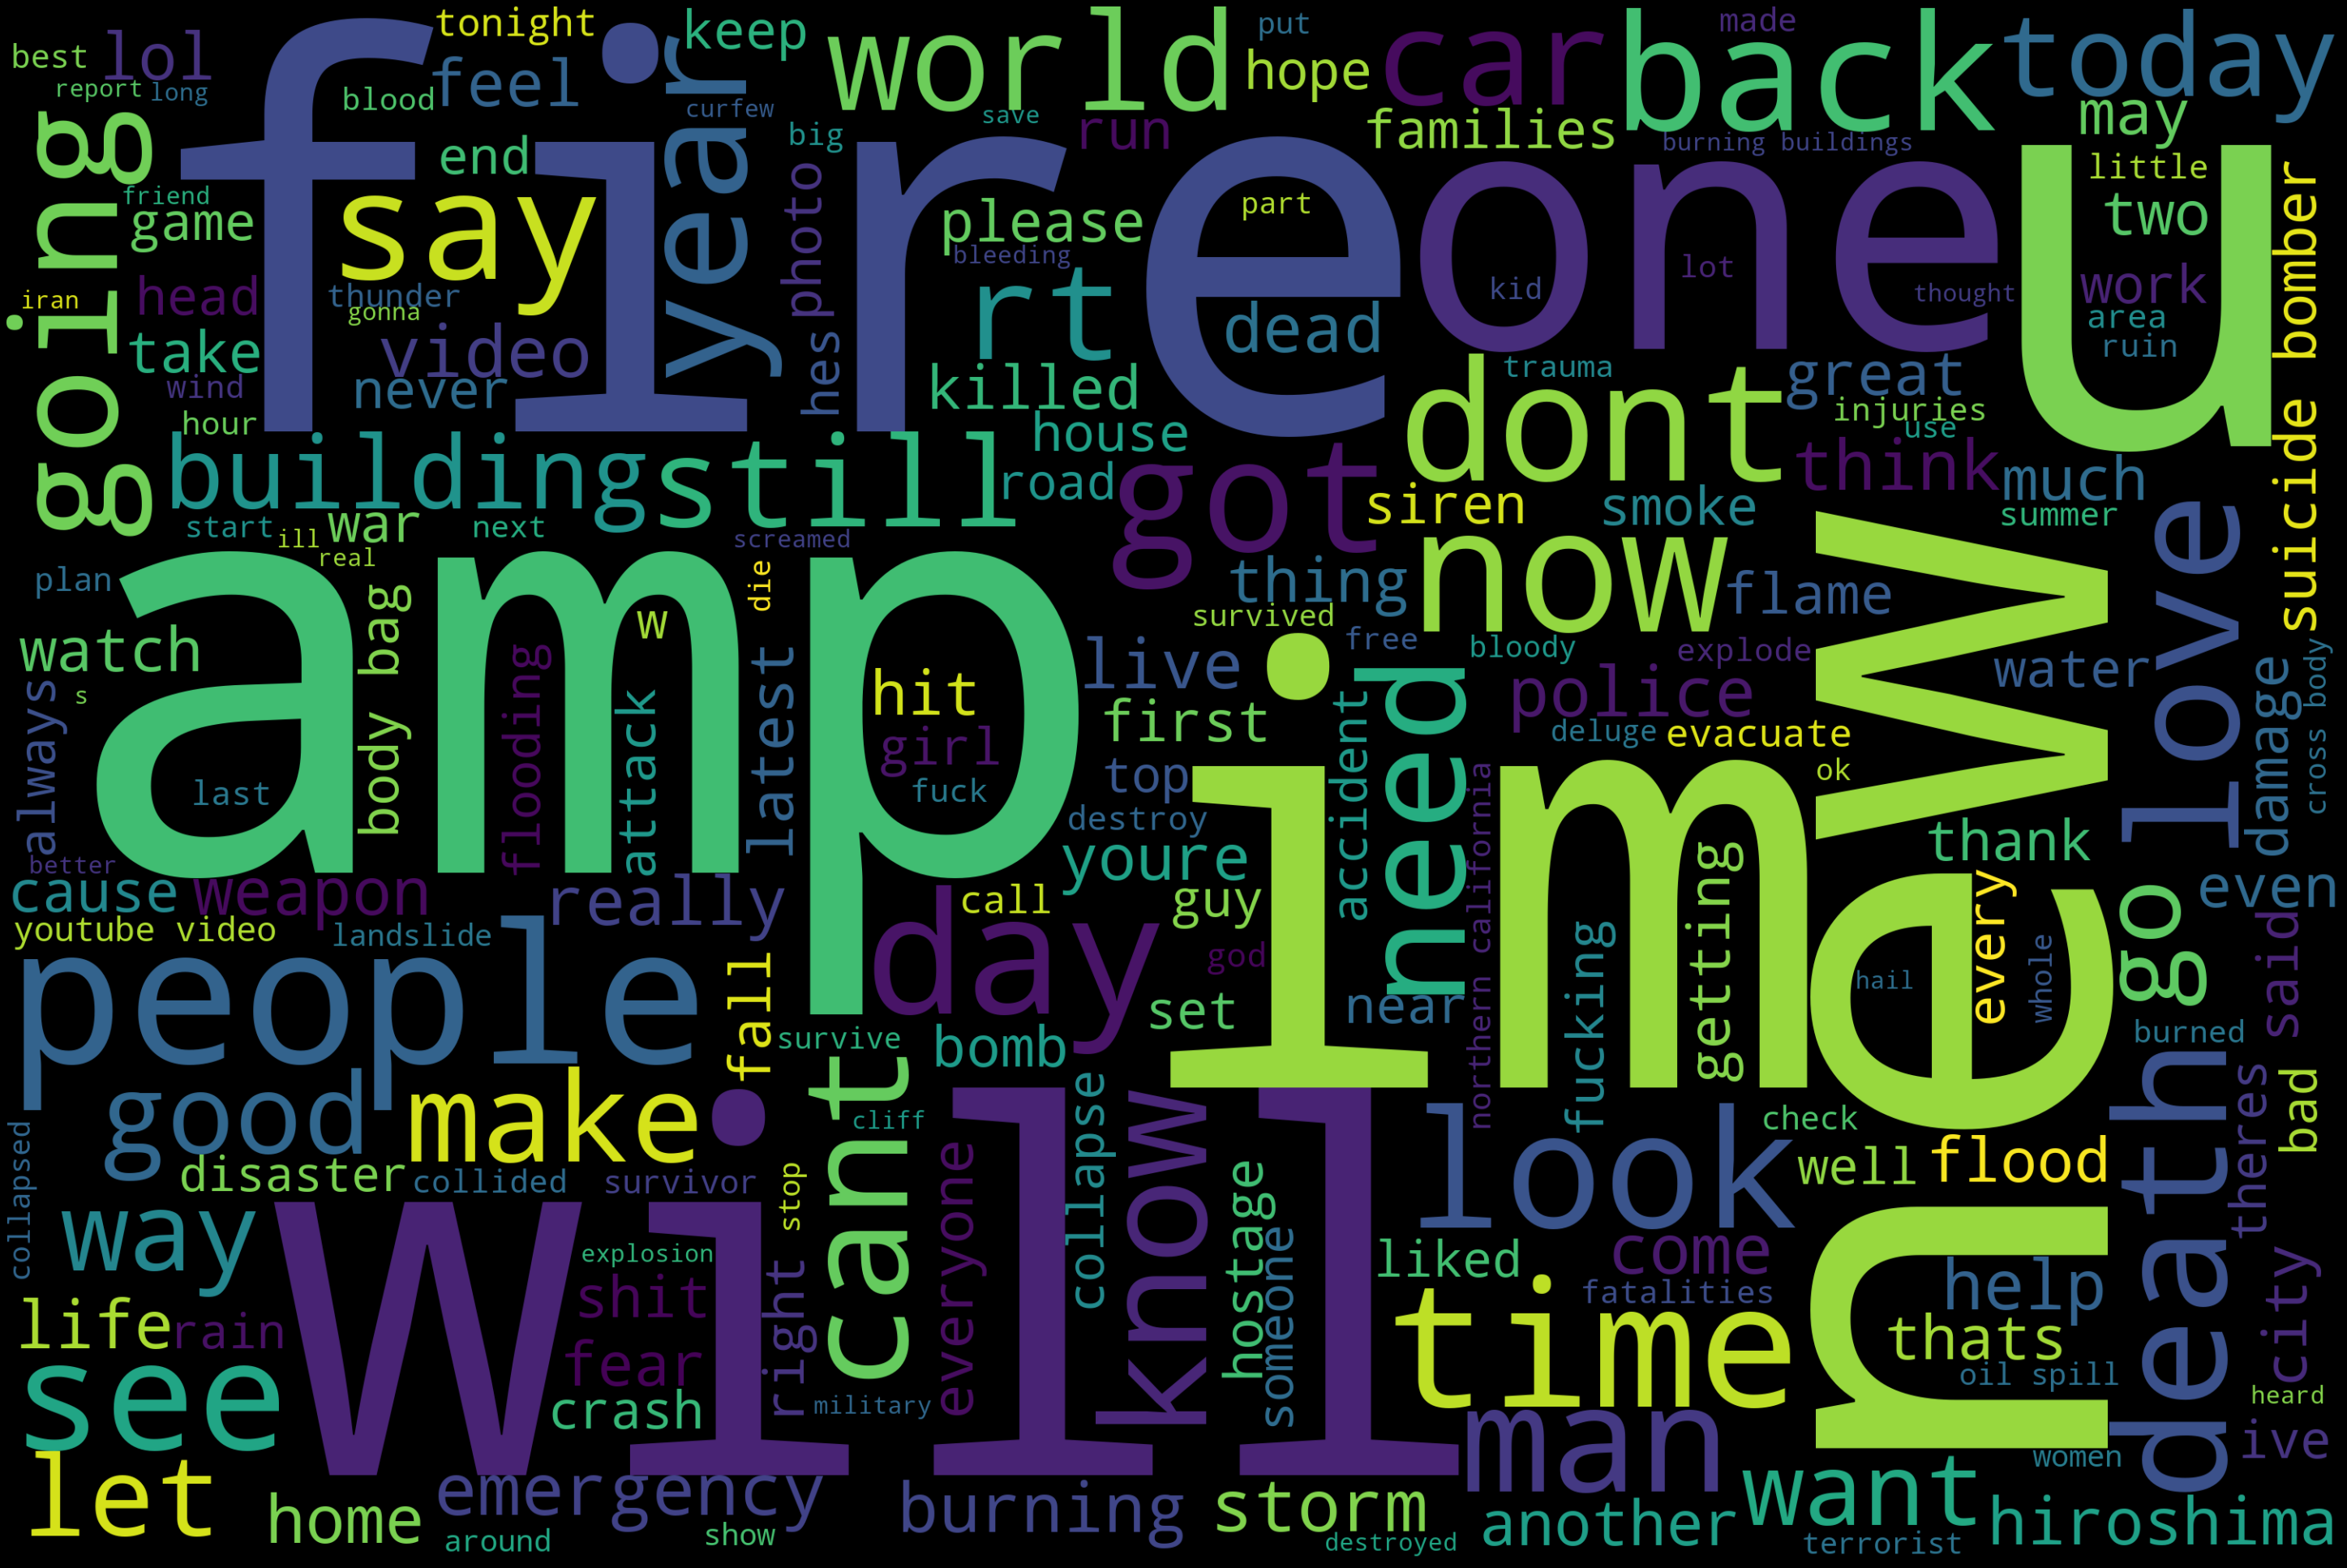

In [21]:
tweets_text = data['text'].str.split(' ')
tweet_data = [" ".join(tweet) for tweet in tweets_text]
all_texts = " ".join(tweet_data)

wordcloud_text = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(all_texts)


fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_text, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Target

Text(0, 0.5, 'Palabra')

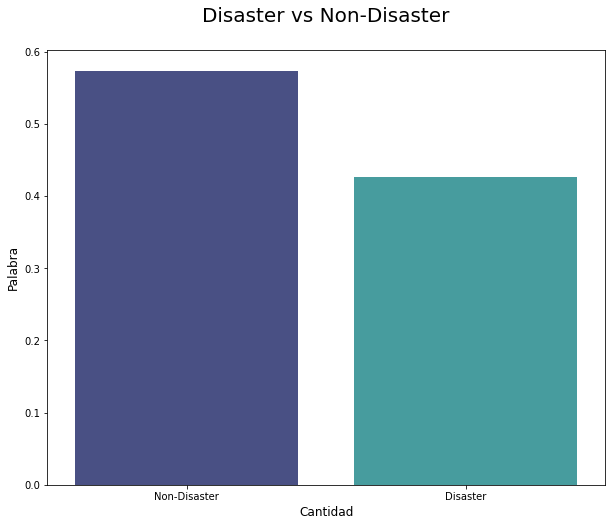

In [12]:
plt.figure(figsize=(10, 8))
target_values = ['Non-Disaster', 'Disaster']
target = data['target'].value_counts(normalize=True)
sns.barplot(x=target_values, y=target, palette='mako')
plt.title('Disaster vs Non-Disaster\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)